In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
#sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
#import cis_functions as f

import cptac
import cptac.utils as u

In [2]:
# note: pass reduced omics # CHECK would include non coding, but none in fm genes

def format_mutated_wt_comparison(reduced_omics_df):
    # Step 2 - Create binary column 
    reduced_omics_df['binary_mutations'] = np.where(
                reduced_omics_df[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = reduced_omics_df[reduced_omics_df.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    mut_status = tumors.drop(columns_to_drop, axis = 1)

    return mut_status

In [3]:
def add_significance_col(results_df, num_comparisons):
    "bonferroni multiple hypothesis"""
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    pval = results_df['P_Value']
    if float(pval[0]) <= bonferroni_cutoff:
        results_df['Significant'] = True
    else: 
        results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


In [4]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# used in pval_annotation
def get_pval_symbol(pval_df):
    if pval_df.iloc[0:,2].bool() == True:
        pval_symbol = '*'
    else:
        pval_symbol = 'ns'
    return pval_symbol

def pval_annotation(pval_df, plotted_df):
    # pval symbol
    num_pvals = len(pval_df)
    omics_col = plotted_df.columns[0]
    

    # annotation for Mutated and Wiltype
    if num_pvals == 1:
        mut_pval = pval_df.loc[pval_df.index == "Mutated/Wildtype"]
        mut_pval_symbol = get_pval_symbol(pval_df)
        
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    # annotation for Missense, Truncation and Wildtype
    elif num_pvals == 2:
        # Missense
        miss_pval = pval_df.loc[pval_df.index == "Missense/Wildtype"]
        miss_pval_symbol = get_pval_symbol(miss_pval)
    
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
        
        # Truncation 
        trunc_pval = pval_df.loc[pval_df.index == "Truncation/Wildtype"]
        trunc_pval_symbol = get_pval_symbol(trunc_pval)
        
        x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
        y2, h2 = plotted_df[omics_col].max() + .15, .05     
        plt.plot([x3, x3, x4, x4], #draw horizontal line
                 [y2, y2+h2, y2+h2, y2], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x3+x4)*.5, # half between x coord
                 y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [5]:
cptac.download(dataset="GBM")

True

In [6]:
brain = cptac.Gbm()
gene = ["RB1","TP53"]

In [92]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = ['RB1','TP53'], omics_df_name = 'transcriptomics', omics_genes = ["ARF1","CASP3","CASP7","CASP9","BID","APAF1"])
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels
reduced_transcript_mutations = reduced_transcript_mutations.loc[reduced_transcript_mutations['Sample_Status'] == "Tumor"]
reduced_transcript_mutations

Name,APAF1_transcriptomics,ARF1_transcriptomics,BID_transcriptomics,CASP3_transcriptomics,CASP7_transcriptomics,CASP9_transcriptomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status
Sample_ID,,,,,,,,,,,,,
S001,121584.924414,8.755904e+05,172824.575576,282155.799107,94757.856468,96998.516011,[Splice_Site],[p.X654_splice],Single_mutation,[Missense_Mutation],[p.G266R],Single_mutation,Tumor
S002,127543.335077,1.143540e+06,129224.679935,338958.989116,152333.359473,74437.051565,[Frame_Shift_Del],[p.F117Lfs*8],Single_mutation,[Missense_Mutation],[p.K132R],Single_mutation,Tumor
S003,159717.892717,1.105102e+06,201906.077059,397178.747372,122607.182408,63949.687681,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S004,108777.078394,9.163683e+05,49391.078560,155861.917352,57094.934837,62775.668485,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Multiple_mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Multiple_mutation,Tumor
S005,132169.668704,1.052542e+06,81962.838430,272108.246951,84073.177294,57767.798647,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,97803.075601,1.158203e+06,52321.706505,214369.829028,103235.606033,59698.141303,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S101,103953.919377,1.002822e+06,122409.939821,555823.390118,89316.707465,69803.234116,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S102,99337.423473,1.335898e+06,160571.493943,304616.038824,79108.511221,54400.821984,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor


In [93]:
#Classify all mutations as 'mutation' and all wildtypes as 'wildtype'
reduced_transcript_mutations = reduced_transcript_mutations.replace({'Wildtype_Tumor':'Wildtype','Single_mutation':'Mutation','Multiple_mutation':'Mutation'})
reduced_transcript_mutations

Name,APAF1_transcriptomics,ARF1_transcriptomics,BID_transcriptomics,CASP3_transcriptomics,CASP7_transcriptomics,CASP9_transcriptomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status
Sample_ID,,,,,,,,,,,,,
S001,121584.924414,8.755904e+05,172824.575576,282155.799107,94757.856468,96998.516011,[Splice_Site],[p.X654_splice],Mutation,[Missense_Mutation],[p.G266R],Mutation,Tumor
S002,127543.335077,1.143540e+06,129224.679935,338958.989116,152333.359473,74437.051565,[Frame_Shift_Del],[p.F117Lfs*8],Mutation,[Missense_Mutation],[p.K132R],Mutation,Tumor
S003,159717.892717,1.105102e+06,201906.077059,397178.747372,122607.182408,63949.687681,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
S004,108777.078394,9.163683e+05,49391.078560,155861.917352,57094.934837,62775.668485,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Mutation,Tumor
S005,132169.668704,1.052542e+06,81962.838430,272108.246951,84073.177294,57767.798647,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,97803.075601,1.158203e+06,52321.706505,214369.829028,103235.606033,59698.141303,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
S101,103953.919377,1.002822e+06,122409.939821,555823.390118,89316.707465,69803.234116,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
S102,99337.423473,1.335898e+06,160571.493943,304616.038824,79108.511221,54400.821984,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor


In [94]:

for ind, row in reduced_transcript_mutations.iterrows():
    if row['RB1_Mutation_Status'] == 'Mutation' and row["TP53_Mutation_Status"] == 'Mutation':
        reduced_transcript_mutations.loc[ind, 'Mutation_Exclusivity'] = 'Both'
        
    elif row['RB1_Mutation_Status'] == 'Mutation' and row["TP53_Mutation_Status"] != 'Mutation':
        reduced_transcript_mutations.loc[ind, 'Mutation_Exclusivity'] = 'TP53_Only'
        
    elif row['RB1_Mutation_Status'] != 'Mutation' and row["TP53_Mutation_Status"] == 'Mutation':
        reduced_transcript_mutations.loc[ind, 'Mutation_Exclusivity'] = "RB1_Only"
        
    else:
        reduced_transcript_mutations.loc[ind, 'Mutation_Exclusivity'] = 'Neither'

In [95]:
reduced_transcript_mutations.head(100)

Name,APAF1_transcriptomics,ARF1_transcriptomics,BID_transcriptomics,CASP3_transcriptomics,CASP7_transcriptomics,CASP9_transcriptomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status,Mutation_Exclusivity
Sample_ID,,,,,,,,,,,,,,
S001,121584.924414,8.755904e+05,172824.575576,282155.799107,94757.856468,96998.516011,[Splice_Site],[p.X654_splice],Mutation,[Missense_Mutation],[p.G266R],Mutation,Tumor,Both
S002,127543.335077,1.143540e+06,129224.679935,338958.989116,152333.359473,74437.051565,[Frame_Shift_Del],[p.F117Lfs*8],Mutation,[Missense_Mutation],[p.K132R],Mutation,Tumor,Both
S003,159717.892717,1.105102e+06,201906.077059,397178.747372,122607.182408,63949.687681,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S004,108777.078394,9.163683e+05,49391.078560,155861.917352,57094.934837,62775.668485,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Mutation,Tumor,Both
S005,132169.668704,1.052542e+06,81962.838430,272108.246951,84073.177294,57767.798647,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,97803.075601,1.158203e+06,52321.706505,214369.829028,103235.606033,59698.141303,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S101,103953.919377,1.002822e+06,122409.939821,555823.390118,89316.707465,69803.234116,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S102,99337.423473,1.335898e+06,160571.493943,304616.038824,79108.511221,54400.821984,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither


In [96]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
trans_col_list = ["APAF1"+'_transcriptomics', "ARF1_transcriptomics","BID_transcriptomics","CASP3_transcriptomics","CASP7_transcriptomics","CASP9_transcriptomics"]


In [97]:
# compare wildtype (neither) and Both
Both_wt = reduced_transcript_mutations.loc[(reduced_transcript_mutations['Mutation_Exclusivity'] != "TP53_Only")]
Both_wt = Both_wt.loc[(Both_wt['Mutation_Exclusivity'] != "RB1_Only")]
print("Doing t-test comparison for Both and Wildtype")
RB1_results_both = wrap_ttest_return_all(Both_wt, 'Mutation_Exclusivity',trans_col_list, num_freq_mut_genes)
RB1_results_both = RB1_results_both.rename(index = {0: "Both/Wildtype"})
RB1_results_both

Doing t-test comparison for Both and Wildtype


,Comparison,P_Value,Significant
Both/Wildtype,CASP7_transcriptomics,0.064486,False
1,CASP3_transcriptomics,0.067417,False
2,BID_transcriptomics,0.379926,False
3,CASP9_transcriptomics,0.440074,False
4,ARF1_transcriptomics,0.826987,False
5,APAF1_transcriptomics,0.980519,False


In [98]:
cols_drop = ['RB1_Mutation','TP53_Mutation','RB1_Location','TP53_Location','RB1_Mutation_Status','TP53_Mutation_Status','Sample_Status']
reduced_transcript_mutations = reduced_transcript_mutations.drop(cols_drop,axis=1)

melted = pd.melt(reduced_transcript_mutations, id_vars='Mutation_Exclusivity')
melted

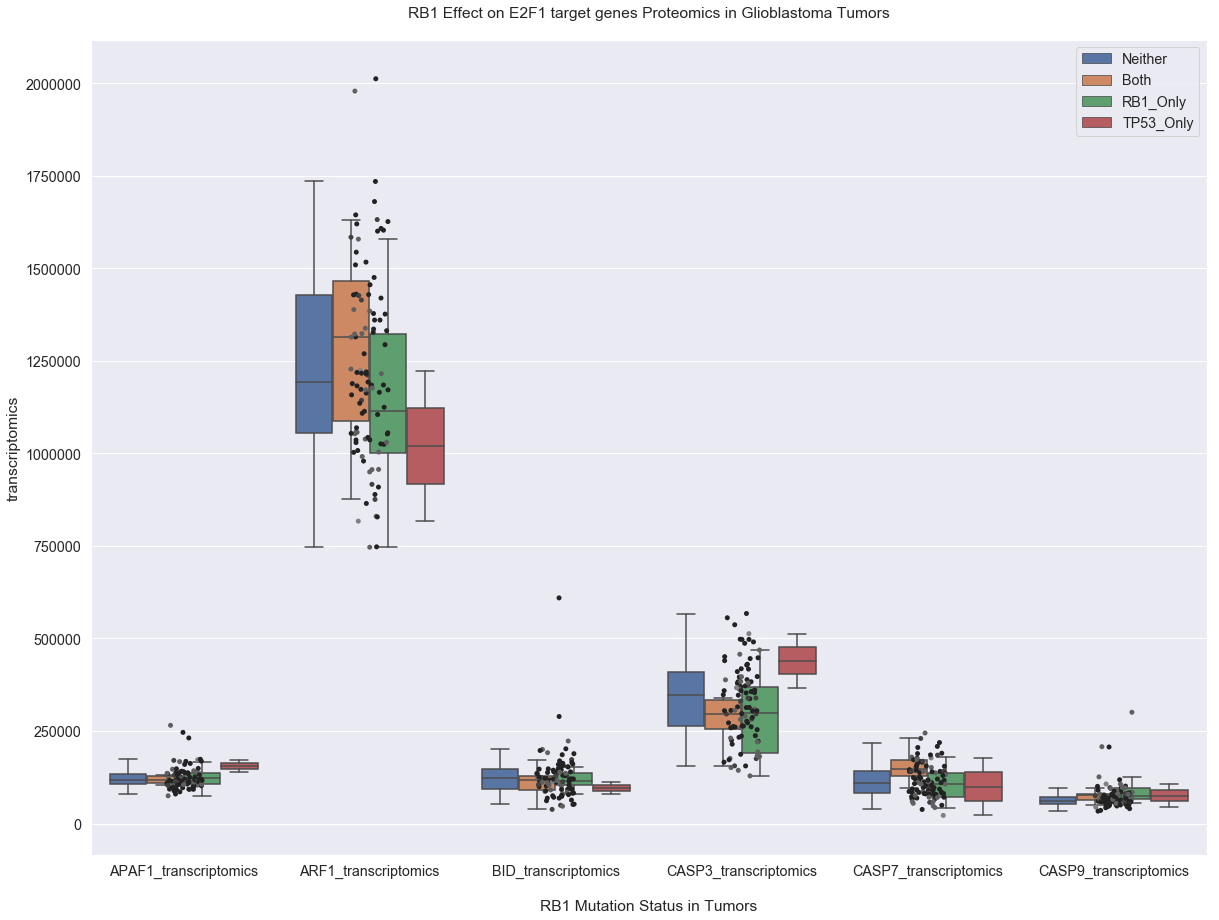

In [117]:
gene = "RB1"
plt.rcParams['figure.figsize']=(20,15)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = melted, x = 'Name',
                          y = 'value', hue='Mutation_Exclusivity', hue_order = ['Neither', 'Both', 'RB1_Only', "TP53_Only"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on E2F1 target genes" +" Proteomics in Glioblastoma Tumors\n")
cis_boxplot = sns.stripplot(data= melted, x = 'Name',
                            y = 'value', hue='Mutation_Exclusivity',jitter = True, color = ".5", hue_order = ['Neither', "Both",'RB1_Only', "TP53_Only"])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# format legend
handles, labels = cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:4], labels[0:4])


plt.show()
plt.clf()
plt.close()

# Proteomics 


In [128]:
gene = ["RB1","TP53"]
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
proteomic_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = ["ARF1","CASP3","CASP7","CASP9","BID","APAF1"])

proteomic_mutations = proteomic_mutations.loc[proteomic_mutations['Sample_Status'] == "Tumor"]

In [129]:
#Classify all mutations as 'mutation' and all wildtypes as 'wildtype'
proteomic_mutations = proteomic_mutations.replace({'Wildtype_Tumor':'Wildtype','Single_mutation':'Mutation','Multiple_mutation':'Mutation'})
proteomic_mutations

Name,ARF1_proteomics,CASP3_proteomics,CASP7_proteomics,CASP9_proteomics,BID_proteomics,APAF1_proteomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status
Sample_ID,,,,,,,,,,,,,
S001,-1.079632,-0.103299,-0.478298,0.104011,0.121788,-0.082649,[Splice_Site],[p.X654_splice],Mutation,[Missense_Mutation],[p.G266R],Mutation,Tumor
S002,NaN,-0.068945,-0.051566,0.273644,0.156544,0.152627,[Frame_Shift_Del],[p.F117Lfs*8],Mutation,[Missense_Mutation],[p.K132R],Mutation,Tumor
S003,NaN,-0.359319,-0.246385,0.113761,0.188308,-0.012196,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
S004,-0.080557,-0.912002,-0.940367,-0.237273,-0.239060,-0.512124,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Mutation,Tumor
S005,-1.079538,0.185203,-0.215475,-0.284076,-0.345157,-0.295338,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,NaN,-0.611290,0.068494,0.233175,0.305273,0.024076,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
S101,0.749539,1.039982,0.051622,0.135453,0.025732,0.445996,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor
S102,1.224083,-0.346653,-0.558564,-0.309800,0.023515,-0.136322,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor


In [130]:
for ind, row in proteomic_mutations.iterrows():
    if row['RB1_Mutation_Status'] == 'Mutation' and row["TP53_Mutation_Status"] == 'Mutation':
        proteomic_mutations.loc[ind, 'Mutation_Exclusivity'] = 'Both'
        
    elif row['RB1_Mutation_Status'] == 'Mutation' and row["TP53_Mutation_Status"] != 'Mutation':
        proteomic_mutations.loc[ind, 'Mutation_Exclusivity'] = 'TP53_Only'
        
    elif row['RB1_Mutation_Status'] != 'Mutation' and row["TP53_Mutation_Status"] == 'Mutation':
        proteomic_mutations.loc[ind, 'Mutation_Exclusivity'] = "RB1_Only"
        
    else:
        proteomic_mutations.loc[ind, 'Mutation_Exclusivity'] = 'Neither'

In [131]:
proteomic_mutations

Name,ARF1_proteomics,CASP3_proteomics,CASP7_proteomics,CASP9_proteomics,BID_proteomics,APAF1_proteomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status,Mutation_Exclusivity
Sample_ID,,,,,,,,,,,,,,
S001,-1.079632,-0.103299,-0.478298,0.104011,0.121788,-0.082649,[Splice_Site],[p.X654_splice],Mutation,[Missense_Mutation],[p.G266R],Mutation,Tumor,Both
S002,NaN,-0.068945,-0.051566,0.273644,0.156544,0.152627,[Frame_Shift_Del],[p.F117Lfs*8],Mutation,[Missense_Mutation],[p.K132R],Mutation,Tumor,Both
S003,NaN,-0.359319,-0.246385,0.113761,0.188308,-0.012196,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S004,-0.080557,-0.912002,-0.940367,-0.237273,-0.239060,-0.512124,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Mutation,Tumor,Both
S005,-1.079538,0.185203,-0.215475,-0.284076,-0.345157,-0.295338,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,NaN,-0.611290,0.068494,0.233175,0.305273,0.024076,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S101,0.749539,1.039982,0.051622,0.135453,0.025732,0.445996,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S102,1.224083,-0.346653,-0.558564,-0.309800,0.023515,-0.136322,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither


In [132]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["APAF1"+'_proteomics', "ARF1_proteomics","BID_proteomics","CASP3_proteomics","CASP7_proteomics","CASP9_proteomics"]
proteomic_mutations

Name,ARF1_proteomics,CASP3_proteomics,CASP7_proteomics,CASP9_proteomics,BID_proteomics,APAF1_proteomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status,Mutation_Exclusivity
Sample_ID,,,,,,,,,,,,,,
S001,-1.079632,-0.103299,-0.478298,0.104011,0.121788,-0.082649,[Splice_Site],[p.X654_splice],Mutation,[Missense_Mutation],[p.G266R],Mutation,Tumor,Both
S002,NaN,-0.068945,-0.051566,0.273644,0.156544,0.152627,[Frame_Shift_Del],[p.F117Lfs*8],Mutation,[Missense_Mutation],[p.K132R],Mutation,Tumor,Both
S003,NaN,-0.359319,-0.246385,0.113761,0.188308,-0.012196,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S004,-0.080557,-0.912002,-0.940367,-0.237273,-0.239060,-0.512124,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Mutation,Tumor,Both
S005,-1.079538,0.185203,-0.215475,-0.284076,-0.345157,-0.295338,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,NaN,-0.611290,0.068494,0.233175,0.305273,0.024076,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S101,0.749539,1.039982,0.051622,0.135453,0.025732,0.445996,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S102,1.224083,-0.346653,-0.558564,-0.309800,0.023515,-0.136322,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither


In [63]:
# compare wildtype (neither) and Both
Prot_Both_wt = proteomic_mutations.loc[(proteomic_mutations['Mutation_Exclusivity'] != "TP53_Only")]
Prot_Both_wt = Prot_Both_wt.loc[(Prot_Both_wt['Mutation_Exclusivity'] != "RB1_Only")]
Prot_Both_wt

Name,ARF1_proteomics,CASP3_proteomics,CASP7_proteomics,CASP9_proteomics,BID_proteomics,APAF1_proteomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status,Mutation_Exclusivity
Sample_ID,,,,,,,,,,,,,,
S001,-1.079632,-0.103299,-0.478298,0.104011,0.121788,-0.082649,[Splice_Site],[p.X654_splice],Mutation,[Missense_Mutation],[p.G266R],Mutation,Tumor,Both
S002,NaN,-0.068945,-0.051566,0.273644,0.156544,0.152627,[Frame_Shift_Del],[p.F117Lfs*8],Mutation,[Missense_Mutation],[p.K132R],Mutation,Tumor,Both
S003,NaN,-0.359319,-0.246385,0.113761,0.188308,-0.012196,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S004,-0.080557,-0.912002,-0.940367,-0.237273,-0.239060,-0.512124,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Mutation,Tumor,Both
S005,-1.079538,0.185203,-0.215475,-0.284076,-0.345157,-0.295338,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S111,0.563308,-2.175506,-0.614856,-0.069430,-0.403765,-0.738951,[Wildtype_Normal],[No_mutation],Wildtype_Normal,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal,Neither
S112,NaN,-1.586803,-1.149258,-0.438419,-0.419027,-0.747015,[Wildtype_Normal],[No_mutation],Wildtype_Normal,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal,Neither
S113,NaN,-2.055661,-1.059149,-0.348722,-0.398427,-1.012836,[Wildtype_Normal],[No_mutation],Wildtype_Normal,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal,Neither


In [66]:
print("Doing t-test comparison for Both and Wildtype")
RB1_results_both = u.wrap_ttest(Prot_Both_wt, 'Mutation_Exclusivity',prot_col_list, num_freq_mut_genes,return_all=True)
#RB1_results_both = RB1_results_both.rename(index = {0: "Both/Wildtype"})
RB1_results_both

Doing t-test comparison for Both and Wildtype
6 significant comparisons!


,Comparison,P_Value
0,CASP9_proteomics,0.062638
1,CASP7_proteomics,0.173310
2,APAF1_proteomics,0.295184
3,CASP3_proteomics,0.703487
4,ARF1_proteomics,0.790643
5,BID_proteomics,0.803008


In [45]:
Prot_Both_wt

Name,ARF1_proteomics,CASP3_proteomics,CASP7_proteomics,CASP7_proteomics,CASP9_proteomics,BID_proteomics,APAF1_proteomics,RB1_Mutation,RB1_Location,RB1_Mutation_Status,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status,Mutation_Exclusivity
Sample_ID,,,,,,,,,,,,,,,
S001,-1.079632,-0.103299,-0.478298,-0.478298,0.104011,0.121788,-0.082649,[Splice_Site],[p.X654_splice],Mutation,[Missense_Mutation],[p.G266R],Mutation,Tumor,Both
S002,NaN,-0.068945,-0.051566,-0.051566,0.273644,0.156544,0.152627,[Frame_Shift_Del],[p.F117Lfs*8],Mutation,[Missense_Mutation],[p.K132R],Mutation,Tumor,Both
S003,NaN,-0.359319,-0.246385,-0.246385,0.113761,0.188308,-0.012196,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
S004,-0.080557,-0.912002,-0.940367,-0.940367,-0.237273,-0.239060,-0.512124,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Mutation,"[Missense_Mutation, Missense_Mutation]","[p.R248Q, p.R158H]",Mutation,Tumor,Both
S005,-1.079538,0.185203,-0.215475,-0.215475,-0.284076,-0.345157,-0.295338,[Wildtype_Tumor],[No_mutation],Wildtype,[Wildtype_Tumor],[No_mutation],Wildtype,Tumor,Neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S111,0.563308,-2.175506,-0.614856,-0.614856,-0.069430,-0.403765,-0.738951,[Wildtype_Normal],[No_mutation],Wildtype_Normal,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal,Neither
S112,NaN,-1.586803,-1.149258,-1.149258,-0.438419,-0.419027,-0.747015,[Wildtype_Normal],[No_mutation],Wildtype_Normal,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal,Neither
S113,NaN,-2.055661,-1.059149,-1.059149,-0.348722,-0.398427,-1.012836,[Wildtype_Normal],[No_mutation],Wildtype_Normal,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal,Neither


In [133]:
cols_drop = ['RB1_Mutation','TP53_Mutation','RB1_Location','TP53_Location','RB1_Mutation_Status','TP53_Mutation_Status','Sample_Status']
proteomic_mutations = proteomic_mutations.drop(cols_drop,axis=1)

melted = pd.melt(proteomic_mutations, id_vars='Mutation_Exclusivity')
melted

,Mutation_Exclusivity,Name,value
0,Both,ARF1_proteomics,-1.079632
1,Both,ARF1_proteomics,NaN
2,Neither,ARF1_proteomics,NaN
3,Both,ARF1_proteomics,-0.080557
4,Neither,ARF1_proteomics,-1.079538
...,...,...,...
589,Neither,APAF1_proteomics,0.024076
590,Neither,APAF1_proteomics,0.445996
591,Neither,APAF1_proteomics,-0.136322
592,Neither,APAF1_proteomics,-0.264630


In [134]:
proteomic_mutations['Mutation_Exclusivity'].value_counts()

Neither      65
RB1_Only     24
Both          8
TP53_Only     2
Name: Mutation_Exclusivity, dtype: int64

[Text(0, 0, 'ARF1_proteomics'),
 Text(0, 0, 'CASP3_proteomics'),
 Text(0, 0, 'CASP7_proteomics'),
 Text(0, 0, 'CASP9_proteomics'),
 Text(0, 0, 'BID_proteomics'),
 Text(0, 0, 'APAF1_proteomics')]

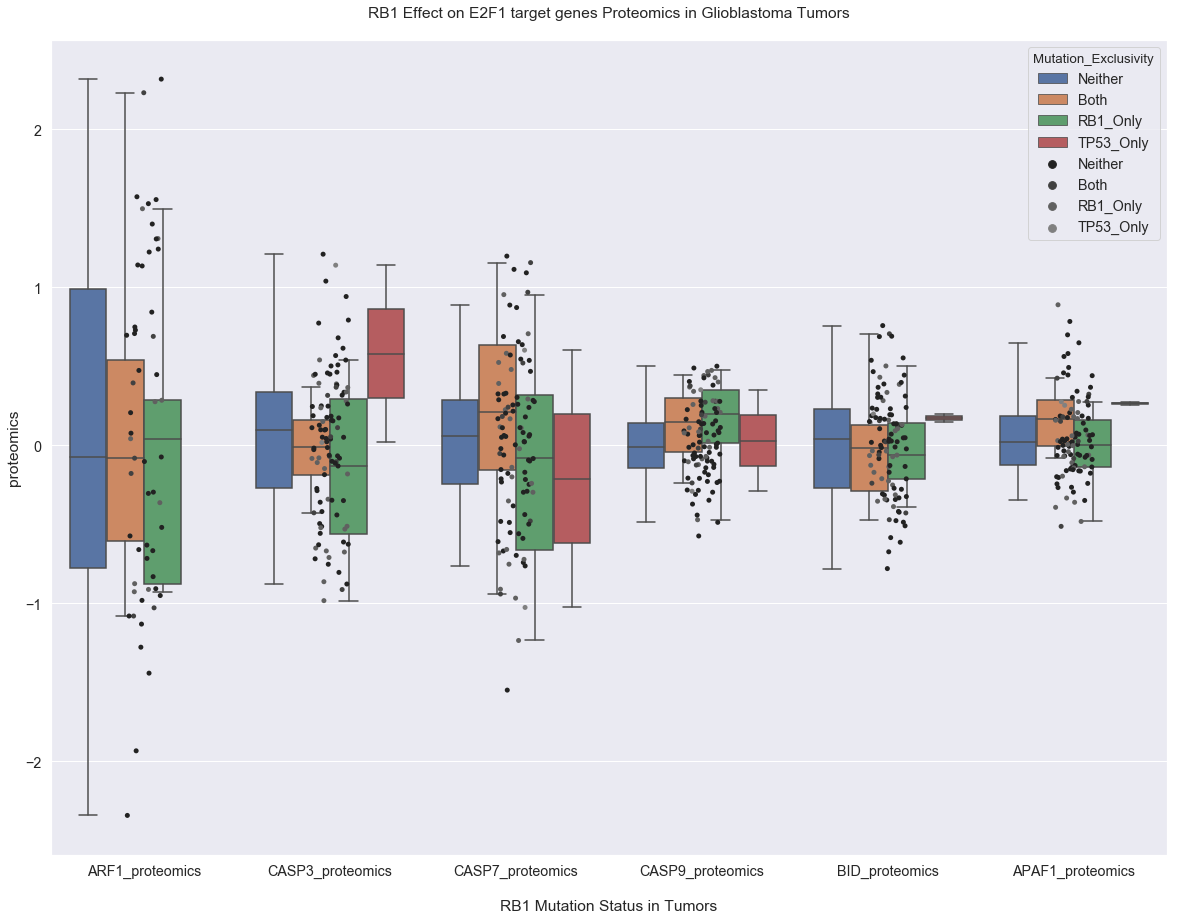

In [136]:
gene = "RB1"
plt.rcParams['figure.figsize']=(20,15)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = melted, x = 'Name',
                          y = 'value', hue='Mutation_Exclusivity', hue_order = ['Neither', 'Both', 'RB1_Only', "TP53_Only"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on E2F1 target genes" +" Proteomics in Glioblastoma Tumors\n")
cis_boxplot = sns.stripplot(data= melted, x = 'Name',
                            y = 'value', hue='Mutation_Exclusivity',jitter = True, color = ".5", hue_order = ['Neither', "Both",'RB1_Only', "TP53_Only"])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'proteomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())